# Homework: Constrained Food Recommender

**Author:** Volodymyr Savchuk

In this assignment, you will implement both Content Based and Collaborative Filtering Recommenders and backtracking search (or local search) on your own

100% finished homework should contain EDA, Item and User profiles generation, Content-Based Recommender, Collaborative Filtering Recommender, and soluton to CSP problem of assigning recommendations to brekfast, lunch and dinner.

## Imports

In [557]:
#basics
import numpy as np
import pandas as pd
import plotly.express as px
import folium
import folium.plugins as plg
import scipy
import sklearn
from scipy.sparse.linalg import svds
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

#misc
import time
import warnings


#viz
import matplotlib.pyplot as plt
import seaborn as sns 
import matplotlib.gridspec as gridspec 
import matplotlib.gridspec as gridspec 

#settings
start_time=time.time()
color = sns.color_palette()
sns.set_style("dark")
warnings.filterwarnings("ignore")

%matplotlib inline

## Data loading

You will work with subset of [Academic Yelp Dataset](https://www.kaggle.com/yelp-dataset/yelp-dataset) containing list of restaurants in **yelp_business.csv** and reviews of the users in **yelp_reviews.parquet**

In [436]:
import pandas as pd

df_yelp_business = pd.read_csv("yelp_business.csv").drop(columns=["Unnamed: 0"])
df_yelp_reviews = pd.read_parquet("yelp_reviews.parquet")

# Leave only users with at least 3 reviews
users_count = df_yelp_reviews.groupby("user_id").count()[["business_id"]] 
users_to_use = users_count[users_count["business_id"] > 2]
df_yelp_reviews = df_yelp_reviews[df_yelp_reviews["user_id"].isin(users_to_use.index)]

## Exploratory data analysis

Here you will explore the data to find out what is the distribution of business categories, hours, places, user reviews, etc.

This step is needed to proceed later with item and user profiling and to clean your data if there are duplicates (e.g. duplicated reviews, the same businesses under different ids, categories tags which are highly correlated) or some artifacts not related to the main task.

(5 points)

### Quick look at the data

In [437]:
df_yelp_business.shape

(5748, 14)

In [438]:
df_yelp_reviews.shape

(79934, 9)

### Dropping the duplicate rows

In [439]:
# Rows containing duplicate data
duplicate_rows_reviews_df = df_yelp_reviews[df_yelp_reviews.duplicated()]
print("number of duplicate rows in reviews: ", duplicate_rows_reviews_df.shape[0])

number of duplicate rows in reviews:  0


In [440]:
# Rows containing duplicate data
duplicate_rows_business_df = df_yelp_business[df_yelp_business.duplicated()]
print("number of duplicate rows in : businesses", duplicate_rows_business_df.shape[0])

number of duplicate rows in : businesses 0


Conclusion: we have no duplicates

In [441]:
df_yelp_business.describe()

,is_open,latitude,longitude,review_count,stars
count,5748.000000,5748.000000,5748.000000,5748.000000,5748.000000
mean,0.660926,40.099318,-92.418212,78.830376,3.413361
std,0.473436,4.996454,16.625489,179.539451,0.807876
min,0.000000,33.218471,-115.435431,3.000000,1.000000
25%,0.000000,35.259613,-112.072108,8.000000,3.000000
50%,1.000000,41.221624,-81.377509,24.000000,3.500000
75%,1.000000,43.708129,-79.427870,74.000000,4.000000
max,1.000000,51.288372,-72.988628,4138.000000,5.000000


In [442]:
df_yelp_reviews.describe()

,cool,funny,stars,useful
count,79934.000000,79934.000000,79934.000000,79934.000000
mean,0.819163,0.610466,3.727813,1.506756
std,1.933984,1.660643,1.171350,2.658814
min,0.000000,0.000000,1.000000,0.000000
25%,0.000000,0.000000,3.000000,0.000000
50%,0.000000,0.000000,4.000000,1.000000
75%,1.000000,1.000000,5.000000,2.000000
max,93.000000,75.000000,5.000000,98.000000


In [443]:
df_yelp_business.head()

,address,attributes,business_id,categories,city,hours,is_open,latitude,longitude,name,postal_code,review_count,stars,state
0,404 E Green St,"{'RestaurantsAttire': ""u'casual'"", 'Restaurant...",pQeaRpvuhoEqudo3uymHIQ,"Ethnic Food, Food Trucks, Specialty Food, Impo...",Champaign,"{'Monday': '11:30-14:30', 'Tuesday': '11:30-14...",1,40.110446,-88.233073,The Empanadas House,61820,5,4.5,IL
1,4508 E Independence Blvd,"{'RestaurantsGoodForGroups': 'True', 'OutdoorS...",CsLQLiRoafpJPJSkNX2h5Q,"Food, Restaurants, Grocery, Middle Eastern",Charlotte,NaN,0,35.194894,-80.767442,Middle East Deli,28205,5,3.0,NC
2,300 John Street,"{'GoodForKids': 'True', 'RestaurantsTakeOut': ...",lu7vtrp_bE9PnxWfA8g4Pg,"Japanese, Fast Food, Food Court, Restaurants",Thornhill,NaN,1,43.820492,-79.398466,Banzai Sushi,L3T 5W4,7,4.5,ON
3,"4550 East Cactus Rd, #KSFC-4","{'GoodForKids': 'True', 'RestaurantsTakeOut': ...",vjTVxnsQEZ34XjYNS-XUpA,"Food, Pretzels, Bakeries, Fast Food, Restaurants",Phoenix,"{'Monday': '10:0-21:0', 'Tuesday': '10:0-21:0'...",1,33.602822,-111.983533,Wetzel's Pretzels,85032,10,4.0,AZ
4,9595 W Tropicana Ave,"{'Alcohol': ""u'none'"", 'WiFi': ""u'no'"", 'GoodF...",fnZrZlqW1Z8iWgTVDfv_MA,"Mexican, Restaurants, Fast Food",Las Vegas,NaN,0,36.099738,-115.301568,Carl's Jr,89147,15,2.5,NV


In [444]:
df_yelp_reviews.head()

,business_id,cool,date,funny,review_id,stars,text,useful,user_id
4,IS4cv902ykd8wj1TR0N3-A,0,2017-01-14 21:56:57,0,6TdNDKywdbjoTkizeMce8A,4,happy day finally canes near casa yes others g...,0,UgMW8bLE0QMJDCkQ1Ax5Mg
6,Pthe4qk5xh4n-ef-9bvMSg,0,2015-11-05 23:11:05,0,ZayJ1zWyWgY9S_TRLT_y9Q,5,really good place simple decor amazing food gr...,1,aq_ZxGHiri48TUXJlpRkCQ
9,Ws8V970-mQt2X9CwCuT5zw,1,2009-10-13 04:16:41,0,z4BCgTkfNtCu4XY5Lp97ww,4,twice nice laid back tried weekend southern me...,3,jOERvhmK6_lo_XGUBPws_w
16,d4qwVw4PcN-_2mK2o1Ro1g,0,2015-02-02 06:28:00,0,bVTjZgRNq8ToxzvtiVrqMA,1,10pm super bowl sunday already closed weak won...,0,2hRe26HSCAWbFRn5WChK-Q
22,9Jo1pu0y2zU6ktiwQm6gNA,20,2016-12-04 03:15:21,19,sgTnHfeaEvyOoWX4TCgkuQ,4,coconut fish cafe fantastic five stars fish ca...,24,A0j21z2Q1HGic7jW6e9h7A


### Number of Businesses and Users

In [445]:
print('Number of businesses: ', len(df_yelp_business.business_id.unique()))
print('Number of users: ', len(df_yelp_reviews.user_id.unique()))

Number of businesses:  5748
Number of users:  16120


In [446]:
# how much null values we have
df_yelp_business.isnull().sum()

address           52
attributes       120
business_id        0
categories         0
city               0
hours           1249
is_open            0
latitude           0
longitude          0
name               0
postal_code       17
review_count       0
stars              0
state              0
dtype: int64

In [447]:
# how much null values we have
df_yelp_reviews.isnull().sum()

business_id    0
cool           0
date           0
funny          0
review_id      0
stars          0
text           0
useful         0
user_id        0
dtype: int64

### Cities sorted by number of restaurants

In [448]:
business_per_city_df = df_yelp_business.city.value_counts()
business_per_city_df

Toronto                731
Las Vegas              655
Montréal               393
Phoenix                383
Calgary                280
                      ... 
Medicine Hat             1
Crafton                  1
Pointe-Aux-Trembles      1
Moreland Hills           1
Centennial               1
Name: city, Length: 354, dtype: int64

There are  354  cities in Yelp dataset!



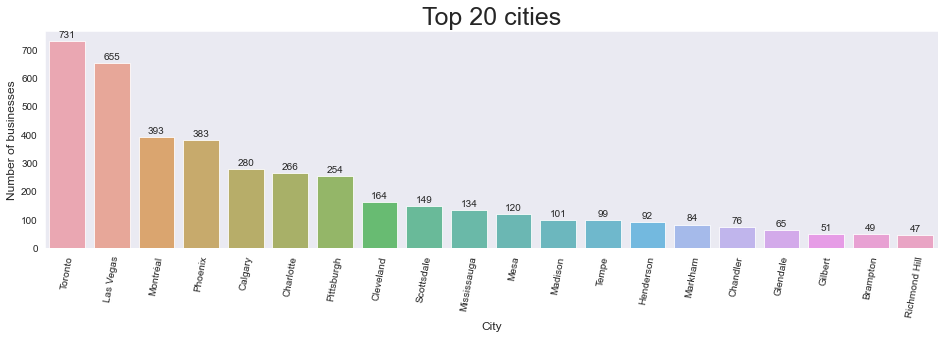

In [449]:
print("There are ",len(business_per_city_df)," cities in Yelp dataset!")
print()
#prep for chart
x=business_per_city_df.sort_values(ascending=False)
x=x.iloc[0:20] # taking only the 20th the most significant

#chart
plt.figure(figsize=(16,4))
ax = sns.barplot(x.index, x.values, alpha=0.8)#,color=color[5])
plt.title("Top 20 cities",fontsize=25)
locs, labels = plt.xticks()
plt.setp(labels, rotation=80)
plt.ylabel('Number of businesses', fontsize=12)
plt.xlabel('City', fontsize=12)

#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

### Business ratings distribution

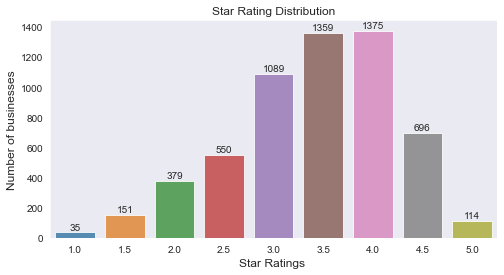

In [450]:
x=df_yelp_business['stars'].value_counts()
x=x.sort_index()

#plot
plt.figure(figsize=(8,4))
ax= sns.barplot(x.index, x.values, alpha=0.8)
plt.title("Star Rating Distribution")
plt.ylabel('Number of businesses', fontsize=12)
plt.xlabel('Star Ratings ', fontsize=12)

#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

### Restaurants on the map

In [451]:
restaurants_map = folium.Map(prefer_canvas=True)

def plot_circle_of_location(location):
    folium.CircleMarker(location=(location.latitude, location.longitude), redius=1).add_to(restaurants_map)

df_yelp_business.apply(plot_circle_of_location, axis=1)
restaurants_map

Conclusion: we see that we have 11 main locations, where the restaurants from Yelp dataset are located.

### Categories distribution

There are  411  different types/categories of Businesses in Yelp!



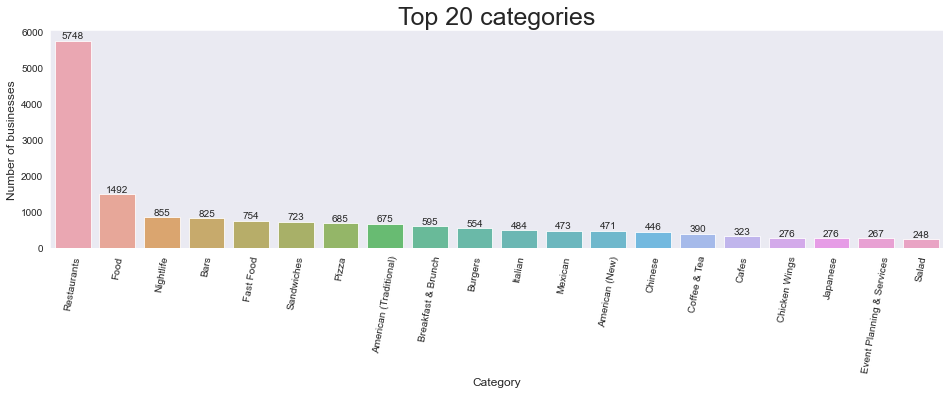

In [452]:
# What are the popular business categories?
business_cats=','.join(df_yelp_business['categories'])

cats=pd.DataFrame(map(str.strip, business_cats.split(',')),columns=['category'])
x=cats.category.value_counts()
print("There are ",len(x)," different types/categories of Businesses in Yelp!")
print()
#prep for chart
x=x.sort_values(ascending=False)
x=x.iloc[0:20] # taking only the 20th the most significant

#chart
plt.figure(figsize=(16,4))
ax = sns.barplot(x.index, x.values, alpha=0.8)#,color=color[5])
plt.title("Top 20 categories",fontsize=25)
locs, labels = plt.xticks()
plt.setp(labels, rotation=80)
plt.ylabel('Number of businesses', fontsize=12)
plt.xlabel('Category', fontsize=12)

#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()
most_frequent_categories = x.iloc[0:15]

In [453]:
list(most_frequent_categories.index)

['Restaurants',
 'Food',
 'Nightlife',
 'Bars',
 'Fast Food',
 'Sandwiches',
 'Pizza',
 'American (Traditional)',
 'Breakfast & Brunch',
 'Burgers',
 'Italian',
 'Mexican',
 'American (New)',
 'Chinese',
 'Coffee & Tea']

### Attributes distribution

In [454]:
from ast import literal_eval

# evaluation of string
df_yelp_business.attributes = df_yelp_business.attributes.apply(lambda value: literal_eval(value) if isinstance(value, str) else value)

In [455]:
attributes_dist = dict()
for attributes_dct in df_yelp_business.attributes:
    if not isinstance(attributes_dct, dict):
        continue

    for attr in attributes_dct.keys():
        attributes_dist[attr] = attributes_dist.get(attr, 0) + 1

frequency_attributes_df = pd.DataFrame(attributes_dist.items(), columns=['Attribute', 'Frequency'])
frequency_attributes_df.set_index('Attribute', inplace=True)
frequency_attributes_df = pd.Series(frequency_attributes_df.Frequency)

There are  38  different attributes of Businesses in Yelp!



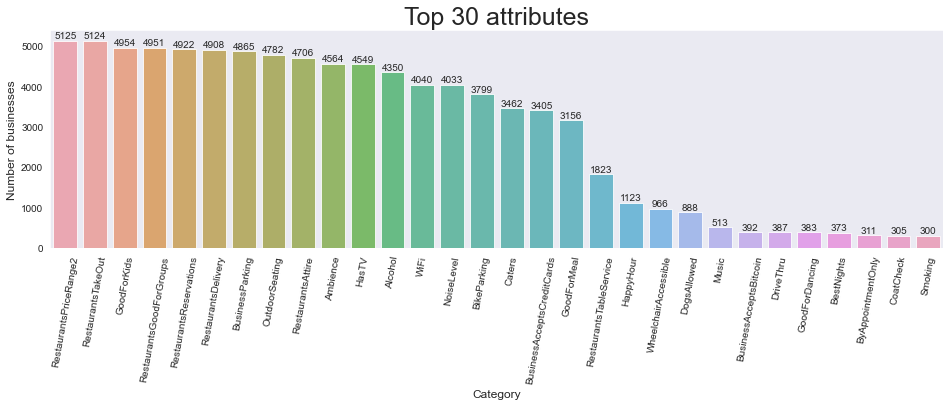

In [456]:
print("There are ",len(frequency_attributes_df)," different attributes of Businesses in Yelp!")
print()
#prep for chart
x=frequency_attributes_df.sort_values(ascending=False)
x=x.iloc[0:30] # taking only the 20th the most significant

#chart
plt.figure(figsize=(16,4))
ax = sns.barplot(x.index, x.values, alpha=0.8)#,color=color[5])
plt.title("Top 30 attributes",fontsize=25)
locs, labels = plt.xticks()
plt.setp(labels, rotation=80)
plt.ylabel('Number of businesses', fontsize=12)
plt.xlabel('Category', fontsize=12)

#adding the text labels
rects = ax.patches
labels = x.values
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 5, label, ha='center', va='bottom')

plt.show()

### User summary stats


In [457]:
user_agg=df_yelp_reviews.groupby('user_id').agg({'review_id':['count'],'date':['min','max'],
                                'useful':['sum'],'funny':['sum'],'cool':['sum'],
                               'stars':['mean']})

In [458]:
user_agg=user_agg.sort_values([('review_id','count')],ascending=True)
print("          Top 10 Users in Yelp")
user_agg.head(10)

          Top 10 Users in Yelp


review_id                date                      \
                           count                 min                 max   
user_id                                                                    
Ub5-3cClw3jBRC2e9GdMXw         3 2011-08-27 16:21:22 2013-03-19 04:29:17   
XLOVIvOaXc-5oy5sR0A1-w         3 2014-10-16 23:39:28 2016-05-30 23:32:31   
XMN5ThRdC7B7ascj4KbpQw         3 2018-02-10 20:24:02 2018-07-27 02:17:27   
XNDUFImg9Tgl7Bhzi8IypQ         3 2016-01-09 14:34:16 2016-01-20 02:43:09   
XNIfMxGPq8rF2QqneygLWQ         3 2016-03-23 00:39:42 2018-06-12 01:03:00   
XNs2G2K0LFMmaP1ceUZQfA         3 2014-09-01 10:40:48 2015-08-03 04:13:37   
XNx-zJzcdfxZHcStYcruQQ         3 2015-10-03 23:14:35 2017-09-03 03:10:51   
XNzChtoNOw706kps82x0Kg         3 2014-10-29 14:00:38 2017-02-24 22:15:40   
XOSjRes1mDv5H2e3mWKCOw         3 2010-01-24 22:45:18 2010-01-31 05:21:36   
XOzuDlByzpoyhA4fV4GMIw         3 2011-08-01 19:15:30 2014-01-04 00:26:13   

                       useful funny cool     stars  
                          sum   sum  sum      mean  
user_id                                             
Ub5-3cClw3jBRC2e9GdMXw      1     0    0  3.333333  
XLOVIvOaXc-5oy5sR0A1-w      1     1    0  2.000000  
XMN5ThRdC7B7ascj4KbpQw      0     0    0  3.000000  
XNDUFImg9Tgl7Bhzi8IypQ      3     0    1  3.333333  
XNIfMxGPq8rF2QqneygLWQ      3     3    0  2.333333  
XNs2G2K0LFMmaP1ceUZQfA      3     3    1  3.333333  
XNx-zJzcdfxZHcStYcruQQ      0     0    0  3.000000  
XNzChtoNOw706kps82x0Kg      9     2    3  4.000000  
XOSjRes1mDv5H2e3mWKCOw      1     0    0  4.000000  
XOzuDlByzpoyhA4fV4GMIw      3     4    1  3.333333

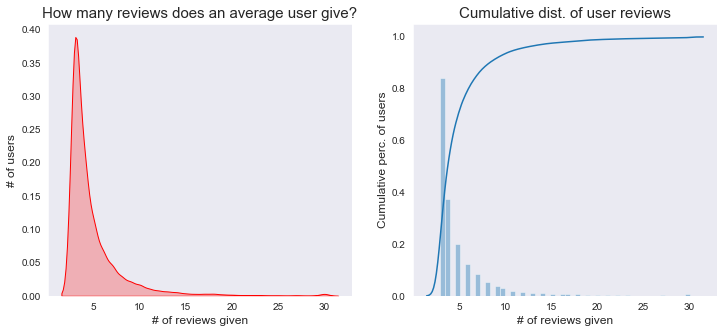

In [459]:
# Cap max reviews to 30 for better visuals
user_agg[('review_id','count')].loc[user_agg[('review_id','count')]>30] = 30
plt.figure(figsize=(12,5))
gridspec.GridSpec(1,2)
plt.subplot2grid((1,2),(0,0))
#Cumulative Distribution
ax=sns.kdeplot(user_agg[('review_id','count')],shade=True,color='r')
plt.title("How many reviews does an average user give?",fontsize=15)
plt.xlabel('# of reviews given', fontsize=12)
plt.ylabel('# of users', fontsize=12)

#Cumulative Distribution
plt.subplot2grid((1,2),(0,1))
sns.distplot(user_agg[('review_id','count')],
             kde_kws=dict(cumulative=True))
plt.title("Cumulative dist. of user reviews",fontsize=15)
plt.ylabel('Cumulative perc. of users', fontsize=12)
plt.xlabel('# of reviews given', fontsize=12)

plt.show()

## Building recommender

First of all you should process user reviews to get the utility matrix containing ratings for users and businesses. There will be a lot of 0 in this matrix and it is better to store such matrices in the specialized data structure for sparce matrices. However, your working dataset is relatively small and we can use simple **pd.DataFrame** to proceed

In [460]:
def create_utility_matrix(reviews: pd.DataFrame, business: pd.DataFrame) -> pd.DataFrame:
    business_ids = business["business_id"].unique()
    users = reviews["user_id"].unique()
    ut_matrix = pd.DataFrame(0, columns=business_ids, index=users)
    number = 0
    for _, review in reviews.iterrows():
        ut_matrix.loc[review["user_id"], review["business_id"]] = review["stars"]
        
    # set zeros to Nan to not influence our reranging
    ut_matrix = ut_matrix.replace(0, np.nan)
    ut_matrix = ut_matrix.astype(pd.SparseDtype("float", np.nan))
    
    # subtracting an average review for all businesses 
    ut_matrix = ut_matrix.sub(ut_matrix.mean(axis=1), axis=0)
    
    # subtracting an average review for that business
    ut_matrix = ut_matrix.sub(ut_matrix.mean(axis=0), axis=1)
    
    # Normalizing to the range (-1, 1)
    ut_matrix /= 4

    return ut_matrix


df_utility_matrix = create_utility_matrix(df_yelp_reviews, df_yelp_business)

In [461]:
df_utility_matrix.head()

,pQeaRpvuhoEqudo3uymHIQ,CsLQLiRoafpJPJSkNX2h5Q,lu7vtrp_bE9PnxWfA8g4Pg,vjTVxnsQEZ34XjYNS-XUpA,fnZrZlqW1Z8iWgTVDfv_MA,rVBPQdeayMYht4Uv_FOLHg,fhNf_sg-XzZ3e7HEVGuOZg,LoRef3ChgZKbxUio-sHgQg,Ga2Bt7xfqoggTypWD5VpoQ,xFc50drSPxXkcLvX5ygqrg,...,2SfSzEd3B7WimeZac23zhg,1dV3qNEv8nNUAX1k3qdE2w,YHCseOJ93wJh0gBcii_2qA,TJt1W9haRm2DKuoZLQ69yA,wM8QNs7uSyDqMJKjBYFPCQ,gp_bu7Ah81qaBY3M0Leffw,PUKOr5bEI87TVHjwijT1xw,zV38gkkEeJ4cVRlSWWQTfQ,H1j34TgbrVZkxeww9xlJTw,F8M0IukXQqR50IRyocRQbg
UgMW8bLE0QMJDCkQ1Ax5Mg,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
aq_ZxGHiri48TUXJlpRkCQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
jOERvhmK6_lo_XGUBPws_w,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2hRe26HSCAWbFRn5WChK-Q,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A0j21z2Q1HGic7jW6e9h7A,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [462]:
df_utility_matrix.shape

(16120, 5748)

In [463]:
df_utility_matrix['lu7vtrp_bE9PnxWfA8g4Pg'][df_utility_matrix['lu7vtrp_bE9PnxWfA8g4Pg'].notna()]

vCbYnQ0DdpHb-vGRZVMkxg   -0.104167
dSTRQSeCqMTbs7l8KF_xJg    0.104167
Name: lu7vtrp_bE9PnxWfA8g4Pg, dtype: Sparse[float64, nan]

## Content-Based Recommender

### Feature engineering

Based on EDA and logic I would like to suggest such features to build business profile:

* 'state'
* categories: 1. 'restaurants',
              2. 'food',
              3. 'nightlife',
              4. 'bars',
              5. 'fast food',
              6. 'sandwiches',
              7. 'pizza',
              8. 'american (traditional)',
              9. 'breakfast & brunch',
              10. 'burgers',
              11. 'italian',
              12. 'mexican',
              13. 'american (new)',
              14. 'chinese',
              15. 'coffee & tea'
* attributes(top 14)
* 'stars'

**Explanation:** I decided to use one-hot encoding technique for attributes and for categories to use tf-idf technique. This was used to make the matrix not so sparse for quicker calculations.



In [464]:
df_yelp_business_processed = df_yelp_business.copy()

#### Adding attributes as features

In [465]:
#prep for chart
frequency_attributes_df.sort_values(ascending=False, inplace=True)
frequency_attributes_df = frequency_attributes_df.iloc[0:14] # taking the top 13 attributes

In [597]:
frequency_attributes_df

Attribute
RestaurantsPriceRange2      5125
RestaurantsTakeOut          5124
GoodForKids                 4954
RestaurantsGoodForGroups    4951
RestaurantsReservations     4922
RestaurantsDelivery         4908
BusinessParking             4865
OutdoorSeating              4782
RestaurantsAttire           4706
Ambience                    4564
HasTV                       4549
Alcohol                     4350
WiFi                        4040
NoiseLevel                  4033
Name: Frequency, dtype: int64

In [466]:
# adding each value of attributes to the business dataframe
for attribute in frequency_attributes_df.index:
    df_yelp_business_processed[attribute] = df_yelp_business_processed.apply(func = lambda row: row['attributes'][attribute]
        if isinstance(row, pd.Series) and isinstance(row['attributes'], dict) and attribute in row['attributes'].keys()
        else 0, axis=1)

#### Dropping unrelevant columns

In [467]:
dropped_columns = ['postal_code', 'address','city', 'review_count', 'BusinessParking', 'Ambience', 'hours', 'attributes']
df_yelp_business_processed = df_yelp_business_processed.drop(labels=dropped_columns, axis=1)

In [468]:
df_yelp_business_processed.head()

,business_id,categories,is_open,latitude,longitude,name,stars,state,RestaurantsPriceRange2,RestaurantsTakeOut,GoodForKids,RestaurantsGoodForGroups,RestaurantsReservations,RestaurantsDelivery,OutdoorSeating,RestaurantsAttire,HasTV,Alcohol,WiFi,NoiseLevel
0,pQeaRpvuhoEqudo3uymHIQ,"Ethnic Food, Food Trucks, Specialty Food, Impo...",1,40.110446,-88.233073,The Empanadas House,4.5,IL,1,True,False,False,False,True,False,u'casual',True,'none',0,u'quiet'
1,CsLQLiRoafpJPJSkNX2h5Q,"Food, Restaurants, Grocery, Middle Eastern",0,35.194894,-80.767442,Middle East Deli,3.0,NC,1,True,True,True,False,0,False,u'casual',0,0,0,0
2,lu7vtrp_bE9PnxWfA8g4Pg,"Japanese, Fast Food, Food Court, Restaurants",1,43.820492,-79.398466,Banzai Sushi,4.5,ON,0,True,True,False,False,True,0,0,0,u'none',0,0
3,vjTVxnsQEZ34XjYNS-XUpA,"Food, Pretzels, Bakeries, Fast Food, Restaurants",1,33.602822,-111.983533,Wetzel's Pretzels,4.0,AZ,1,True,True,True,False,False,False,u'casual',False,u'none',0,0
4,fnZrZlqW1Z8iWgTVDfv_MA,"Mexican, Restaurants, Fast Food",0,36.099738,-115.301568,Carl's Jr,2.5,NV,1,True,True,True,False,False,False,u'casual',False,u'none',u'no',u'average'


#### Data preprocessing

In [469]:
# one-hot encoding for several attributes

one_hot_encoding_cols = ['RestaurantsTakeOut', 'GoodForKids', 'RestaurantsGoodForGroups',
                        'RestaurantsReservations', 'RestaurantsDelivery', 'OutdoorSeating', 'HasTV', 'WiFi']

for attribute in one_hot_encoding_cols:
    df_yelp_business_processed[attribute].replace('None', 0, inplace=True)
    df_yelp_business_processed[attribute].replace('False', 0, inplace=True)
    df_yelp_business_processed[attribute].replace('True', 1, inplace=True)
    df_yelp_business_processed[attribute].replace("u'no'", 0, inplace=True)
    df_yelp_business_processed[attribute].replace("'no'", 0, inplace=True)
    df_yelp_business_processed[attribute].replace("u'free'", 1, inplace=True)
    df_yelp_business_processed[attribute].replace("u'paid'", 1, inplace=True)
    df_yelp_business_processed[attribute].replace("'paid'", 1, inplace=True)
    df_yelp_business_processed[attribute].replace("'free'", 1, inplace=True)

In [470]:
# transforming categorical values into numerical codes
df_yelp_business_processed['RestaurantsAttire'] = df_yelp_business_processed['RestaurantsAttire'].astype('category')
df_yelp_business_processed['Alcohol'] = df_yelp_business_processed['Alcohol'].astype('category')
df_yelp_business_processed['state'] = df_yelp_business_processed['state'].astype('category')
df_yelp_business_processed['RestaurantsPriceRange2'] = df_yelp_business_processed['RestaurantsPriceRange2'].astype('category')

cat_columns = df_yelp_business_processed.select_dtypes(['category']).columns

df_yelp_business_processed[cat_columns] = df_yelp_business_processed[cat_columns].apply(lambda x: x.cat.codes)

In [471]:
df_yelp_business_processed.head()

,business_id,categories,is_open,latitude,longitude,name,stars,state,RestaurantsPriceRange2,RestaurantsTakeOut,GoodForKids,RestaurantsGoodForGroups,RestaurantsReservations,RestaurantsDelivery,OutdoorSeating,RestaurantsAttire,HasTV,Alcohol,WiFi,NoiseLevel
0,pQeaRpvuhoEqudo3uymHIQ,"Ethnic Food, Food Trucks, Specialty Food, Impo...",1,40.110446,-88.233073,The Empanadas House,4.5,3,1,1,0,0,0,1,0,5,1,3,0,u'quiet'
1,CsLQLiRoafpJPJSkNX2h5Q,"Food, Restaurants, Grocery, Middle Eastern",0,35.194894,-80.767442,Middle East Deli,3.0,4,1,1,1,1,0,0,0,5,0,0,0,0
2,lu7vtrp_bE9PnxWfA8g4Pg,"Japanese, Fast Food, Food Court, Restaurants",1,43.820492,-79.398466,Banzai Sushi,4.5,7,0,1,1,0,0,1,0,0,0,7,0,0
3,vjTVxnsQEZ34XjYNS-XUpA,"Food, Pretzels, Bakeries, Fast Food, Restaurants",1,33.602822,-111.983533,Wetzel's Pretzels,4.0,1,1,1,1,1,0,0,0,5,0,7,0,0
4,fnZrZlqW1Z8iWgTVDfv_MA,"Mexican, Restaurants, Fast Food",0,36.099738,-115.301568,Carl's Jr,2.5,5,1,1,1,1,0,0,0,5,0,7,0,u'average'


In [472]:
df_yelp_reviews.head()

,business_id,cool,date,funny,review_id,stars,text,useful,user_id
4,IS4cv902ykd8wj1TR0N3-A,0,2017-01-14 21:56:57,0,6TdNDKywdbjoTkizeMce8A,4,happy day finally canes near casa yes others g...,0,UgMW8bLE0QMJDCkQ1Ax5Mg
6,Pthe4qk5xh4n-ef-9bvMSg,0,2015-11-05 23:11:05,0,ZayJ1zWyWgY9S_TRLT_y9Q,5,really good place simple decor amazing food gr...,1,aq_ZxGHiri48TUXJlpRkCQ
9,Ws8V970-mQt2X9CwCuT5zw,1,2009-10-13 04:16:41,0,z4BCgTkfNtCu4XY5Lp97ww,4,twice nice laid back tried weekend southern me...,3,jOERvhmK6_lo_XGUBPws_w
16,d4qwVw4PcN-_2mK2o1Ro1g,0,2015-02-02 06:28:00,0,bVTjZgRNq8ToxzvtiVrqMA,1,10pm super bowl sunday already closed weak won...,0,2hRe26HSCAWbFRn5WChK-Q
22,9Jo1pu0y2zU6ktiwQm6gNA,20,2016-12-04 03:15:21,19,sgTnHfeaEvyOoWX4TCgkuQ,4,coconut fish cafe fantastic five stars fish ca...,24,A0j21z2Q1HGic7jW6e9h7A


#### Using TF-IDF technique to transform categories into a vector structure

In [473]:
### leaving only the top 15 categories
most_frequent_categories_lst = list(map(str.lower, list(most_frequent_categories.index)))

def choosing_categories(cat_str):
    cat_str = cat_str.lower()
    cat_lst = [x.strip() for x in cat_str.split(',')]
    result = []
    
    for cat in cat_lst:
        if cat in most_frequent_categories_lst:
            result.append(cat)
    return ' '.join(result)


df_yelp_business_processed['important_categories'] = df_yelp_business_processed['categories'].apply(choosing_categories)

In [596]:
most_frequent_categories_lst = list(map(str.lower, list(most_frequent_categories.index)))
len(most_frequent_categories_lst)


15

In [474]:
stopwords_list = stopwords.words('english')

vectorizer = TfidfVectorizer(analyzer='word',
                     ngram_range=(1, 2),
                     min_df=0.003,
                     max_df=0.5,
                     max_features=5000,
                     stop_words=stopwords_list)

item_ids = df_yelp_business_processed['business_id'].tolist()
features_matrix = vectorizer.fit_transform(df_yelp_business_processed['important_categories'])
tfidf_feature_names = vectorizer.get_feature_names()
type(tfidf_matrix)

scipy.sparse.csr.csr_matrix

In [475]:
len(item_ids)

5748

In [476]:
#adding other features to features_matrix

feature_values_array = np.array(df_yelp_business_processed[['stars', 'state', 'RestaurantsPriceRange2', 'RestaurantsTakeOut',
       'GoodForKids', 'RestaurantsGoodForGroups', 'RestaurantsReservations',
       'RestaurantsDelivery', 'OutdoorSeating', 'RestaurantsAttire', 'HasTV',
       'Alcohol', 'WiFi']].values)

categorical_features_matrix = scipy.sparse.coo_matrix(feature_values_array)
features_matrix = scipy.sparse.hstack((features_matrix, categorical_features_matrix)).tocsr()

In [538]:
print(features_matrix[1:3, :].toarray())

[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.54667155 0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.83734713 0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.   

In [478]:
def get_item_profile(item_id):
    idx = item_ids.index(item_id)
    item_profile = features_matrix[idx:idx+1]
    return item_profile

def get_item_profiles(ids):
    item_profiles_list = [get_item_profile(x) for x in ids]
    item_profiles = scipy.sparse.vstack(item_profiles_list)
    return item_profiles

In [496]:
def build_users_profile(person_id, interactions_indexed_df):
    
    
    interactions_person_df = interactions_indexed_df.loc[person_id]
    user_item_profiles = get_item_profiles(interactions_person_df['business_id'])
    
    interactions_person_df['stars'] = interactions_person_df.apply(lambda row: df_utility_matrix.at[row.name, row.business_id], axis=1)
    user_item_strengths = np.array(interactions_person_df['stars']).reshape(-1,1)
    
    #Weighted average of item profiles by the interactions strength
    user_item_strengths_weighted_avg = np.sum(user_item_profiles.multiply(user_item_strengths), axis=0) / np.sum(user_item_strengths)
    user_item_strengths_weighted_avg[np.isnan(user_item_strengths_weighted_avg)] = 0
    try:
        user_profile_norm = sklearn.preprocessing.normalize(user_item_strengths_weighted_avg)
    except ValueError:
        print(user_item_strengths_weighted_avg)
        print(user_item_strengths)
    return user_profile_norm

In [480]:
interactions_indexed_df = df_yelp_reviews[df_yelp_reviews['business_id'] \
                                                   .isin(df_yelp_business_processed['business_id'])].set_index('user_id')


In [501]:
interactions_indexed_df.loc['aq_ZxGHiri48TUXJlpRkCQ']

,business_id,cool,date,funny,review_id,stars,text,useful
user_id,,,,,,,,
aq_ZxGHiri48TUXJlpRkCQ,Pthe4qk5xh4n-ef-9bvMSg,0,2015-11-05 23:11:05,0,ZayJ1zWyWgY9S_TRLT_y9Q,5,really good place simple decor amazing food gr...,1
aq_ZxGHiri48TUXJlpRkCQ,HYhbeLznSWEl6JIYTllVUA,0,2018-05-31 04:49:00,0,ZBGnuFlD-e1xKs-CwwTKfw,4,team lunch place today say cozy seating great ...,0
aq_ZxGHiri48TUXJlpRkCQ,tVyLQzyhhinKcGzlZIFZjQ,0,2016-12-09 23:44:09,0,pUpv8J-knRFgsfwtUXqajg,4,great setting outdoors large group lunch speci...,0


In [539]:
def build_user_profiles() -> pd.DataFrame:
    
    interactions_indexed_df = df_yelp_reviews[df_yelp_reviews['business_id'] \
                                                   .isin(df_yelp_business_processed['business_id'])].set_index('user_id')
    user_profiles = {}
    for person_id in interactions_indexed_df.index.unique():
        user_profiles[person_id] = build_users_profile(person_id, interactions_indexed_df)
    #return pd.DataFrame(0, index=utility_matrix.index, columns=business_profiles.columns)
    return user_profiles

user_profiles = build_user_profiles()

In [543]:
class ContentBasedRecommender:
    
    MODEL_NAME = 'Content-Based'
    
    def __init__(self, items_df=None):
        self.item_ids = item_ids
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def _get_similar_items_to_user_profile(self, user_id, topn=1000):
        #Computes the cosine similarity between the user profile and all item profiles
        cosine_similarities = cosine_similarity(user_profiles[user_id], features_matrix)
        #Gets the top similar items
        similar_indices = cosine_similarities.argsort().flatten()[-topn:]
        #Sort the similar items by similarity
        similar_items = sorted([(item_ids[i], cosine_similarities[0,i]) for i in similar_indices], key=lambda x: -x[1])
        return similar_items
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        similar_items = self._get_similar_items_to_user_profile(user_id)
        #Ignores items the user has already interacted
        similar_items_filtered = list(filter(lambda x: x[0] not in items_to_ignore, similar_items))
        
        recommendations_df = pd.DataFrame(similar_items_filtered, columns=['business_id', 'Rating']) \
                                    .head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'business_id', 
                                                          right_on = 'business_id')[['Rating', 'business_id']]


        return recommendations_df
    
content_based_recommender_model = ContentBasedRecommender(df_yelp_business)

In [544]:
content_based_recommender_model.recommend_items('A0j21z2Q1HGic7jW6e9h7A')

,business_id,Rating
0,_uJcMpvybyltfWAKJBtTtQ,0.959364
1,mgeLg8MBRnfvtGZanl7mUw,0.955257
2,dv2LfEn4p3ncG_1jYIoZ7g,0.949034
3,F4w_GNeV62kxCkTrta7PdA,0.937127
4,GibwaDiqJJ_62x0h3oCyxA,0.936744
5,xN-HyvdrZiWOWK4_sj6Evw,0.932885
6,uWTMa1_JDJRHE7TAKmw3ZA,0.925196
7,W7hCuNdn2gzehta6eSHzgQ,0.922863
8,G96S9vZ0zzZrp0yrdpGctQ,0.921708
9,n9mxpYKigTM6llGAChlAng,0.921045


## Collaborative Filtering Recommender using UV decomposition

In [576]:
#Creating a sparse pivot table with users in rows and items in columns
# users_items_pivot_matrix_df = df_utility_matrix.pivot(index='personId', 
#                                                           columns='contentId', 
#                                                           values='eventStrength')
users_items_pivot_matrix_df = df_utility_matrix.fillna(0)
users_items_pivot_matrix_df.head(10)

,pQeaRpvuhoEqudo3uymHIQ,CsLQLiRoafpJPJSkNX2h5Q,lu7vtrp_bE9PnxWfA8g4Pg,vjTVxnsQEZ34XjYNS-XUpA,fnZrZlqW1Z8iWgTVDfv_MA,rVBPQdeayMYht4Uv_FOLHg,fhNf_sg-XzZ3e7HEVGuOZg,LoRef3ChgZKbxUio-sHgQg,Ga2Bt7xfqoggTypWD5VpoQ,xFc50drSPxXkcLvX5ygqrg,...,2SfSzEd3B7WimeZac23zhg,1dV3qNEv8nNUAX1k3qdE2w,YHCseOJ93wJh0gBcii_2qA,TJt1W9haRm2DKuoZLQ69yA,wM8QNs7uSyDqMJKjBYFPCQ,gp_bu7Ah81qaBY3M0Leffw,PUKOr5bEI87TVHjwijT1xw,zV38gkkEeJ4cVRlSWWQTfQ,H1j34TgbrVZkxeww9xlJTw,F8M0IukXQqR50IRyocRQbg
UgMW8bLE0QMJDCkQ1Ax5Mg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
aq_ZxGHiri48TUXJlpRkCQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
jOERvhmK6_lo_XGUBPws_w,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2hRe26HSCAWbFRn5WChK-Q,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A0j21z2Q1HGic7jW6e9h7A,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
XivuRnPq3D-K5cPiBTztIA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
H3wPBzQCKCKiHcV7GZK4kg,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6UR0kNe3C-ivlF2x1fPHNQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
FmQxARdHGnkclvcVWGEAxw,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
fVILhIglx6RNOXQba5t4kQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [552]:
users_items_pivot_matrix = users_items_pivot_matrix_df.values
users_items_pivot_matrix[:10]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [553]:
users_ids = list(users_items_pivot_matrix_df.index)
users_ids[:10]

['UgMW8bLE0QMJDCkQ1Ax5Mg',
 'aq_ZxGHiri48TUXJlpRkCQ',
 'jOERvhmK6_lo_XGUBPws_w',
 '2hRe26HSCAWbFRn5WChK-Q',
 'A0j21z2Q1HGic7jW6e9h7A',
 'XivuRnPq3D-K5cPiBTztIA',
 'H3wPBzQCKCKiHcV7GZK4kg',
 '6UR0kNe3C-ivlF2x1fPHNQ',
 'FmQxARdHGnkclvcVWGEAxw',
 'fVILhIglx6RNOXQba5t4kQ']

In [555]:
users_items_pivot_sparse_matrix = scipy.sparse.csr.csr_matrix(users_items_pivot_matrix)
users_items_pivot_sparse_matrix

<16120x5748 sparse matrix of type '<class 'numpy.float64'>'
	with 74706 stored elements in Compressed Sparse Row format>

In [558]:
#The number of factors to factor the user-item matrix.
NUMBER_OF_FACTORS_MF = 5748
#Performs matrix factorization of the original user item matrix
#U, sigma, Vt = svds(users_items_pivot_matrix, k = NUMBER_OF_FACTORS_MF)
U, sigma, Vt = svds(users_items_pivot_sparse_matrix, k = NUMBER_OF_FACTORS_MF)

In [559]:
U.shape

(16120, 15)

In [560]:
Vt.shape

(15, 5748)

In [561]:
sigma = np.diag(sigma)
sigma.shape

(15, 15)

In [562]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 
all_user_predicted_ratings

array([[-8.14880821e-21,  8.29955994e-07,  1.81750593e-08, ...,
        -7.76589026e-07,  1.05412706e-06, -9.61406138e-10],
       [-3.44292530e-21, -9.09883754e-09,  3.59473582e-09, ...,
        -2.27395900e-07, -9.17360771e-07,  1.73027012e-08],
       [-3.46486142e-19, -9.80174429e-07,  1.18900567e-08, ...,
         5.20567440e-06,  1.65654589e-06, -7.57506027e-07],
       ...,
       [-1.00316380e-21, -1.92074369e-07,  3.94247435e-09, ...,
         1.15565689e-06,  1.40613167e-06, -1.60634891e-07],
       [-2.23998398e-21, -4.15012723e-08, -6.90619395e-09, ...,
         5.95940034e-08,  1.53579736e-07, -4.66486121e-09],
       [ 8.49586707e-21,  8.97824936e-08, -1.46989315e-08, ...,
         1.99568335e-07,  5.93351335e-09,  1.75455927e-09]])

In [563]:
all_user_predicted_ratings_norm = (all_user_predicted_ratings - all_user_predicted_ratings.min()) / (all_user_predicted_ratings.max() - all_user_predicted_ratings.min())

In [564]:
#Converting the reconstructed matrix back to a Pandas dataframe
cf_preds_df = pd.DataFrame(all_user_predicted_ratings_norm, columns = users_items_pivot_matrix_df.columns, index=users_ids).transpose()
cf_preds_df.head(10)

,UgMW8bLE0QMJDCkQ1Ax5Mg,aq_ZxGHiri48TUXJlpRkCQ,jOERvhmK6_lo_XGUBPws_w,2hRe26HSCAWbFRn5WChK-Q,A0j21z2Q1HGic7jW6e9h7A,XivuRnPq3D-K5cPiBTztIA,H3wPBzQCKCKiHcV7GZK4kg,6UR0kNe3C-ivlF2x1fPHNQ,FmQxARdHGnkclvcVWGEAxw,fVILhIglx6RNOXQba5t4kQ,...,IDjIyzuFfxF_vb2Rn_GFMw,pA8Q4djhX7vkjA4n9GIWWg,AsSz6hfCcgICRCBOaot3Rw,Z9Qw9C78qu3JC_qEcUh8aw,2m14CEXaClD9Fef4i-V-tw,TWt_hQXobwWMPpQVoEvanA,4rwyBw1cK2AsDfcJGkCiRQ,uav6nwbBCZTqCG_W4FiceA,XGufJ5VHHUr2uv2RJt9E9Q,ts364JSfveX9T4oX2NMydQ
pQeaRpvuhoEqudo3uymHIQ,0.537475,0.537475,0.537475,0.537475,0.537475,0.537475,0.537475,0.537475,0.537475,0.537475,...,0.537475,0.537475,0.537475,0.537475,0.537475,0.537475,0.537475,0.537475,0.537475,0.537475
CsLQLiRoafpJPJSkNX2h5Q,0.537476,0.537475,0.537474,0.537475,0.537475,0.537461,0.537474,0.537475,0.537475,0.537478,...,0.537475,0.537477,0.537476,0.537475,0.537494,0.537475,0.537475,0.537475,0.537475,0.537475
lu7vtrp_bE9PnxWfA8g4Pg,0.537475,0.537475,0.537475,0.537475,0.537475,0.537475,0.537475,0.537475,0.537475,0.537474,...,0.537475,0.537474,0.537475,0.537475,0.537475,0.537475,0.537475,0.537475,0.537475,0.537475
vjTVxnsQEZ34XjYNS-XUpA,0.537473,0.537475,0.537470,0.537476,0.537473,0.537475,0.537475,0.537476,0.537475,0.537527,...,0.537476,0.537498,0.537482,0.537475,0.537475,0.537475,0.537475,0.537473,0.537475,0.537475
fnZrZlqW1Z8iWgTVDfv_MA,0.537481,0.537473,0.537468,0.537468,0.537474,0.537475,0.537466,0.537475,0.537475,0.537705,...,0.537476,0.537497,0.537471,0.537475,0.537475,0.537475,0.537475,0.537473,0.537477,0.537475
rVBPQdeayMYht4Uv_FOLHg,0.537475,0.537475,0.537474,0.537475,0.537475,0.537475,0.537475,0.537475,0.537475,0.537475,...,0.537474,0.537473,0.537477,0.537475,0.537475,0.537475,0.537475,0.537475,0.537475,0.537475
fhNf_sg-XzZ3e7HEVGuOZg,0.537493,0.537466,0.537512,0.537463,0.537471,0.537476,0.537556,0.537477,0.537475,0.536758,...,0.537453,0.537487,0.537465,0.537474,0.537475,0.537475,0.537476,0.537485,0.537478,0.537475
LoRef3ChgZKbxUio-sHgQg,0.537475,0.537475,0.537475,0.537475,0.537475,0.537475,0.537475,0.537475,0.537475,0.537474,...,0.537475,0.537477,0.537475,0.537475,0.537475,0.537475,0.537475,0.537475,0.537475,0.537475
Ga2Bt7xfqoggTypWD5VpoQ,0.537475,0.537475,0.537475,0.537474,0.537474,0.537475,0.537475,0.537474,0.537475,0.537459,...,0.537477,0.537472,0.537469,0.537475,0.537475,0.537475,0.537475,0.537477,0.537475,0.537475
xFc50drSPxXkcLvX5ygqrg,0.537460,0.537458,0.536219,0.537479,0.537486,0.537475,0.537503,0.537491,0.537475,0.537444,...,0.537461,0.537482,0.537475,0.537452,0.537474,0.537475,0.537474,0.537484,0.537474,0.537478


In [565]:
len(cf_preds_df.columns)

16120

In [591]:
class CFRecommender:
    
    MODEL_NAME = 'Collaborative Filtering'
    
    def __init__(self, cf_predictions_df, items_df=None):
        self.cf_predictions_df = cf_predictions_df
        self.items_df = items_df
        
    def get_model_name(self):
        return self.MODEL_NAME
        
    def recommend_items(self, user_id, items_to_ignore=[], topn=10, verbose=False):
        # Get and sort the user's predictions
        sorted_user_predictions = self.cf_predictions_df[user_id].sort_values(ascending=False) \
                                    .reset_index().rename(columns={user_id: 'Rating', 'index': 'business_id'})

        # Recommend the highest predicted rating movies that the user hasn't seen yet.
        recommendations_df = sorted_user_predictions[~sorted_user_predictions['business_id'].isin(items_to_ignore)] \
                               .sort_values('Rating', ascending = False) \
                               .head(topn)

        if verbose:
            if self.items_df is None:
                raise Exception('"items_df" is required in verbose mode')

            recommendations_df = recommendations_df.merge(self.items_df, how = 'left', 
                                                          left_on = 'business_id', 
                                                          right_on = 'business_id')[['Rating', 'business_id', 'name']]


        return recommendations_df
    
cf_recommender_model = CFRecommender(cf_preds_df, df_yelp_business_processed)

In [592]:
df_yelp_business_processed.head()

,business_id,categories,is_open,latitude,longitude,name,stars,state,RestaurantsPriceRange2,RestaurantsTakeOut,...,RestaurantsGoodForGroups,RestaurantsReservations,RestaurantsDelivery,OutdoorSeating,RestaurantsAttire,HasTV,Alcohol,WiFi,NoiseLevel,important_categories
0,pQeaRpvuhoEqudo3uymHIQ,"Ethnic Food, Food Trucks, Specialty Food, Impo...",1,40.110446,-88.233073,The Empanadas House,4.5,3,1,1,...,0,0,1,0,5,1,3,0,u'quiet',food restaurants
1,CsLQLiRoafpJPJSkNX2h5Q,"Food, Restaurants, Grocery, Middle Eastern",0,35.194894,-80.767442,Middle East Deli,3.0,4,1,1,...,1,0,0,0,5,0,0,0,0,food restaurants
2,lu7vtrp_bE9PnxWfA8g4Pg,"Japanese, Fast Food, Food Court, Restaurants",1,43.820492,-79.398466,Banzai Sushi,4.5,7,0,1,...,0,0,1,0,0,0,7,0,0,fast food restaurants
3,vjTVxnsQEZ34XjYNS-XUpA,"Food, Pretzels, Bakeries, Fast Food, Restaurants",1,33.602822,-111.983533,Wetzel's Pretzels,4.0,1,1,1,...,1,0,0,0,5,0,7,0,0,food fast food restaurants
4,fnZrZlqW1Z8iWgTVDfv_MA,"Mexican, Restaurants, Fast Food",0,36.099738,-115.301568,Carl's Jr,2.5,5,1,1,...,1,0,0,0,5,0,7,0,u'average',mexican restaurants fast food


In [593]:
cf_recommender_model.recommend_items('A0j21z2Q1HGic7jW6e9h7A')

,business_id,Rating
0,FirWX-Ep5203TsdiGgShKg,0.542998
1,VMr8sgoQOW0fo0qVJENajA,0.542092
2,yNPh5SO-7wr8HPpVCDPbXQ,0.538503
3,1d6c6Q2j2jwVzBfX_dLHlg,0.538290
4,ms7cmWkPiSBDTnz-1sv2kQ,0.538155
5,kBJfBVaXJtPEKLTov1hJdQ,0.537986
6,szhJLmdLDVFTevm8fu0T4A,0.537967
7,hIUKufhwR6Ifn7bi0-phLA,0.537883
8,0FUtlsQrJI7LhqDPxLumEw,0.537843
9,5nZVVPO_cYH9aQeClTP9zA,0.537794


In [10]:
def predict_collaborative_ratings(utility_matrix: pd.DataFrame) -> pd.DataFrame:
    # TODO: User-item collaborative filtering based rating prediction (15 points)
    # TODO: UV-decomposition based rating prediction (optional for 10 extra points)
    pass

df_collaborative_predictions = predict_collaborative_ratings(df_utility_matrix)

## Evaluation

In [11]:
def score_model(utility_matrix: pd.DataFrame, predicted_utility_matrix: pd.DataFrame, model_name="model_0"):
    # TODO: Implement these by hand (each metric 1 point)
    rmse_score = 0
    map_score = 0
    coverage_score = 0
    personalization_score = 0
    intra_list_similarity_score = 0
    
    print("{} RMSE {}".format(model_name, rmse_score))
    print("MAP: {}".format(model_name, map_score))
    print("Coverage: {}".format(model_name, coverage_score))
    print("Personalization: {}".format(model_name, personalization_score))
    print("Intra-list similarity: {}".format(model_name, intra_list_similarity_score))    

score_model(df_content_predictions, df_utility_matrix, "content-based approach")
score_model(df_collaborative_predictions, df_utility_matrix, "collaborative-filtering approach")

content-based approach RMSE 0
MAP: content-based approach
Coverage: content-based approach
Personalization: content-based approach
Intra-list similarity: content-based approach
collaborative-filtering approach RMSE 0
MAP: collaborative-filtering approach
Coverage: collaborative-filtering approach
Personalization: collaborative-filtering approach
Intra-list similarity: collaborative-filtering approach


## Constraint Satisfaction Problem

We can work with the task of planing breakfast, lunch and dinner for particular user as Constraint Satisfaction Problem with

**Domain**: {all_businesses}

**Variables**: {breakfast, lunch, dinner}

**Constraints**: {constrainst regarding individual variable, or several variables at once}

We also have predicted ratings for every business and want to have personalized plan of restaurants. So we won't only satisfy our constraints, but also would like to get the maximum cumulative rating.

Take a look on prepared constraints and finish empty constraints in similar way (some of these constraints may require analytics on business data. e.g. to finish **has_coffee_constraint** you may need to determine all the categories which may include good coffee in their menu)

In [12]:
def is_vegetarian_constraint(business_id):
    return "vegetarian" in df_yelp_business[df_yelp_business["business_id"] == business_id].categories.values[0].lower()

def has_coffee_constraint(business_id):
    # TODO: implement this constraint (1 point)
    return False

def has_alcohol_constraint(business_id):
    # TODO: implement this constraint (1 point)
    return False

def is_open_constraint(business_id):
    # TODO: implement this constraint (1 point)
    return False

def is_open_at_date_at_time_meta_constraint(weekday, time, business_id):
    # TODO: implement this constraint (1 point)
    return False

def is_open_at_monday_at_10am_constraint(business_id):
    return is_open_at_date_at_time("monday", "10:00", business_id)

def all_are_different_constraint(state):
    for time in ["breakfast", "dinner", "lunch"]:
        for _t in ["breakfast", "dinner", "lunch"]:
            if time == _t: continue
            business_categories = set(df_yelp_business[df_yelp_business["business_id"] == state[time]["business_id"]].categories.values[0].split(","))
            _business_categories = set(df_yelp_business[df_yelp_business["business_id"] == state[_t]["business_id"]].categories.values[0].split(","))
            if len(business_categories.intersection(_business_categories)) > \
                    len(business_categories.union(_business_categories)) // 2:
                return False
    return True

def all_are_in_the_same_city_constraint(state):
    # TODO: implement this constraint (1 point)
    return False

def all_are_in_the_same_region_meta_constraint(coordinates, threshold, state):
    # TODO: implement this constraint (1 point). Hint: use haversine distance https://pypi.org/project/haversine/
    return False

def all_are_in_test_region(state):
    return all_are_in_the_same_region_constraint({"lat": 40.110446, "lon": -115.301568}, 400, state)

def at_least_one_visited_place_constraint(state):
    # TODO: implement this constraint (2 points)
    # Make this constraint give more reward for more than one familiar place
    return False

def at_least_one_has_coffee_constraint(state):
    # TODO: implement this constraint (2 points)
    # Make this constraint give more reward for more than one place with coffee
    return False

In [13]:
import random 

random.seed(42)
inspected_user = random.choice(df_yelp_reviews["user_id"].unique())

all_constraints = {
    "breakfast": [has_coffee_constraint, is_open_constraint, is_open_at_monday_at_10am_constraint],
    "lunch": [is_open_constraint],
    "dinner": [is_vegetarian_constraint, has_alcohol_constraint, is_open_constraint],
    "state": [at_least_one_has_coffee_constraint, at_least_one_visited_place_constraint, all_are_in_test_region,
             all_are_in_the_same_city_constraint, all_are_different_constraint]
}

def goal_test(state: dict, constraints: dict):
    cumulative_rating = state["breakfast"]["predicted_rating"]*state["lunch"]["predicted_rating"]*\
                        state["dinner"]["predicted_rating"]
    for k in constraints.keys():
        if k == "state":
            for c in constraints[k]:
                cumulative_rating *= c(state)
        else:
            for c in constraints[k]:
                cumulative_rating *= c(state[k]["business_id"])
    return cumulative_rating


def prepare_restaurants_plan(user_id: str, user_business_ratings: pd.DataFrame, constraints: dict):
    # TODO: assign breakfast, lunch and dinner by solving Constraint Satisfaction Problem 
    # maximizing total score and satisfying all the constraints (it should work with any configuration of constraints)
    
    # You can implement Backtracking (10) + Filtering (10) + Ordering (5) using goal_test
    # OR
    # Local Search (10) + Min-Conflicts heuristic (10) + Ordering (5) with modification of goal test to work as Min-Conflicts heuristic
    
    state = {"user_id" : user_id,
        "breakfast": 
                {"business_id": random.choice(user_business_ratings["business_id"].unique()),
                 "predicted_rating": 0},
            "lunch": 
    {"business_id": random.choice(user_business_ratings["business_id"].unique()),
                 "predicted_rating": 0},
            "dinner": {"business_id": random.choice(user_business_ratings["business_id"].unique()),
                 "predicted_rating": 0}}
    
    state_v = goal_test(state, constraints)

    
    return state

# TODO: replace df_utility_matrix with your best predictions
prepare_restaurants_plan(inspected_user, df_utility_matrix, all_constraints)

KeyError: 'business_id'